In [1]:
import os
import random

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from PIL import Image
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms



In [2]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device = torch.device('cpu')

In [3]:

class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Flatten(),
            nn.Linear(256*45*45,256),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(256, 20)
        self.fc_log_var = nn.Linear(256, 20)

        self.fc_z = nn.Linear(20,256)

        self.decoder = nn.Sequential(
            nn.Linear(256, 256*45*45),
            nn.ReLU(),
            nn.Unflatten(1,(256,45,45)),
            
            nn.ConvTranspose2d(256, 64, 3, 3, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 3, 2, 2, 1),
            nn.Sigmoid()
        )
    
    def encode(self,x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)
        return mu,log_var
    
    def reparameterise(self, mu, logvar):
        epsilon = torch.randn_like(mu)
        return mu + epsilon * torch.exp(logvar / 2)
    
    def decode(self, z):
        z = self.fc_z(z)
        recon_x = self.decoder(z)
        return recon_x
    
    def forward(self, x):
        mu , log_var = self.encode(x)
        z = self.reparameterise(mu, log_var)
        recon_x = self.decode(z)
        
        return recon_x, mu, log_var

In [4]:
rootpath = 'D:\\NLOS\\DataSet\\Mnist\\train\\image\\'
image_url = '0_5_0.png'
a = os.listdir(rootpath)

In [5]:
from torchvision.io import read_image

In [6]:
image_path = os.path.join(rootpath, image_url)
image = torch.unsqueeze(read_image(image_path).to(torch.float), dim = 0).to(device)
image.shape

torch.Size([1, 3, 720, 720])

In [7]:
class NLOS_dataset(Dataset):
    def __init__(self, image_path, target_image_path):
        self.image_path = image_path
        self.target_image_path = target_image_path
        
        self.image_labels = os.listdir(image_path)
        self.target_image_labels = os.listdir(target_image_path)
        
    def __len__(self):
        return len(self.image_labels)
    
    def __getitem__(self, idx):
        imagepath = os.path.join(self.image_path, self.image_labels[idx])
        image = torch.tensor(read_image(imagepath))
        
        targetimage_path = os.path.join(self.target_image_path, self.target_image_labels[idx])
        target_image = torch.tensor(read_image(targetimage_path))
        return image/255, target_image/255
        

In [8]:
root_image = 'D:\\NLOS\\DataSet\\Mnist\\train\\image\\'
root_target_image = 'D:\\NLOS\\DataSet\\Mnist\\train\\label\\'
train_dataset = NLOS_dataset(root_image, root_target_image)
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

#

In [9]:

print(device)
model = ConvVAE().to(device)
#print(model)
pred , _ , _ = model(image)

cpu


In [10]:
kl_loss = lambda mu, logvar: -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
recon_loss = lambda recon_x, x: F.mse_loss(recon_x, x, size_average=False)

In [13]:
epochs = 1000
batch_size = 64
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(dataloader, model, kl_loss, recon_loss, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        recon_x, mu, logvar = model(x)
        
        recon = recon_loss(recon_x, y)
        kl = kl_loss(mu, logvar)

        loss = recon + kl
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss = loss.item()
            print(f"loss: {loss:>7f}")
            
for i in range(epochs):
    train(train_dataloader, model, kl_loss, recon_loss, optimizer)

C:\Users\shelter\AppData\Local\Temp\ipykernel_86664\1937242969.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(read_image(imagepath))
C:\Users\shelter\AppData\Local\Temp\ipykernel_86664\1937242969.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_image = torch.tensor(read_image(targetimage_path))


loss:     nan
loss:     nan


KeyboardInterrupt: 

In [124]:
img = torch.squeeze(pred,dim = 0)
image = img.permute(1, 2, 0)
image.shape

torch.Size([256, 256, 3])

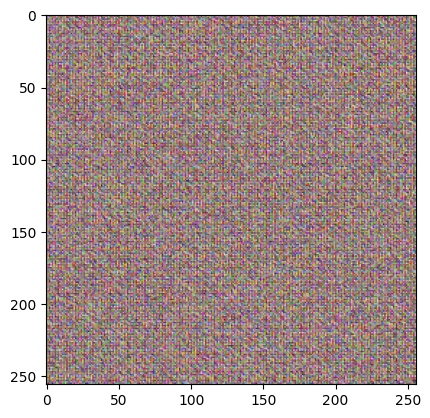

In [126]:
plt.imshow(image.detach().numpy())
plt.show()